In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing and utils:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

# Models:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
 
# Evaluation metrics:
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Question 1. 
### List as many use cases for the dataset as possible.

* Predicting a car's assigned insurance risk rating 
* Predicting the relative average loss payment per insured vehicle year
* Predicting the price of a car
* Clustering the cars into groups with similar attributes 

## Question 2. 
### Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1’s business.

Predicting a car's price and clustering the cars into segments are both useful use cases for Auto1's business.

As Auto1 is buying used cars, checks and repairs them before reselling them predicting a car's price can be used to determine the sale price of the car.

Clustering the cars into groups on the other hand can be useful to present similar types of cars to customers  according to their individual preferences.

In the following I am going to implement a simple model to predict the price of a car.

## Question 3. 
### Implement the model you described in question 2. The code has to retrieve the data, train and test a statistical model, and report relevant performance criteria. 


In [2]:
d = pd.read_csv('Auto1-DS-TestData.csv', na_values='?')
print(d.shape)
d.head()

(205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [3]:
# Removing entries where price is missing.
d = d[~d['price'].isnull()]

# Removing variables that are related to insurance risk and loss payments
d = d.drop(['symboling', 'normalized-losses'], axis=1)

d.shape

(201, 24)

#### Target variable price:

Skewness of price:1.8096753391


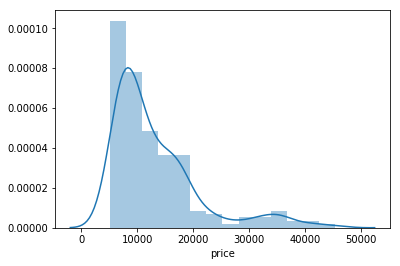

In [4]:
# Checking whether target variable is skewed.

sns.distplot(d['price'])
print('Skewness of price:' + str(d.price.skew()))

Skewness of price after log transform: 0.678652072804


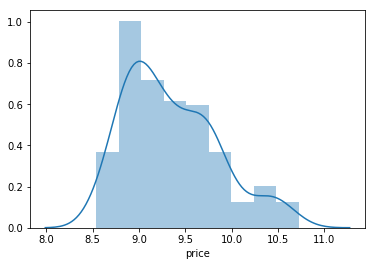

In [5]:
# Log transform of price variable to reduce skewness

d['price'] = np.log(d['price'])

sns.distplot(d['price'])
print('Skewness of price after log transform: ' + str(d.price.skew()))
# The value closer to 0 means it is less skewed.

#### Categorical and numeric variables:

In [6]:
# Converts 'num-of-cylinders' to numeric.

cylinders = pd.DataFrame({'num-of-cylinders': d['num-of-cylinders'].unique(), 
                          'number-of-cylinders': [4, 6, 5, 3, 12, 2, 8]})

d = pd.merge(d, cylinders, on = 'num-of-cylinders')
d.drop('num-of-cylinders', axis = 1, inplace=True)

In [7]:
# Defines categorical and numeric variables.

num = d.select_dtypes(include=['int64', 'float64']).columns.ravel()
cat = d.select_dtypes(include=['object']).columns.ravel()
cols = np.append(cat, num)

,price
price,1.000000
curb-weight,0.891455
horsepower,0.833103
engine-size,0.829967
width,0.798082


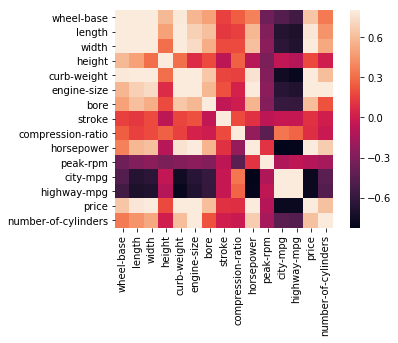

In [8]:
# Investigating correlation of numeric values with target variable.

corr = d[num].corr() 
sns.heatmap(corr, vmax=.8, square=True)

pd.DataFrame(corr.price.sort_values(ascending=False)).head(5)

#### Preproessing for modeling.

In [9]:
# Converts categorical columns to codes and determines position of categorical variables
# (this is required for the One Hot Encoder later).

cat_id = []
for i in cat:
    cat_id = np.append(cat_id, d.columns.get_loc(i))
cat_id = cat_id.astype(int)

for i in cat:
    d.loc[:,i] = np.int64(d[i].astype('category').cat.codes)
    d.loc[:,i] = d.loc[:,i].replace([-1], np.nan)
d = d.apply(pd.to_numeric)

In [10]:
# Defines imputer (mode for categorical, median for numerical).

class DataFrameImputer(TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
    # This is required to apply GridSearchCV to the pipeline.
    def get_params(self, *args, **kwargs):
        return {}

In [11]:
# Defines root mean squared error for model evaluation.

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [12]:
# Splits data into train / test set.

X = d.drop('price', axis = 1).copy()
y = d['price'].reset_index(drop=True)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(201, 23)
(201,)


##### Model 1: Linear Regression

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Computes and prints model evaluation metrics.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("""
RMSE:
  * Training: {rmse_train}
  * Testing: {rmse_test}

R squared:
  * Training: {r2_train}
  * Testing: {r2_test}
""".format(
        rmse_train=str(rmse(y_train, y_train_pred)),
        rmse_test=str(rmse(y_test, y_test_pred)),
        r2_train=str(model.score(X_train, y_train)),
        r2_test=str(model.score(X_test, y_test))
    ))

In [14]:
# Builds pipeline including imputer, hot encoder, standard scaler, and the model.

m = make_pipeline(
    DataFrameImputer(),
    OneHotEncoder(categorical_features=cat_id, sparse=False, handle_unknown='ignore'),
    StandardScaler(),
    LinearRegression()
)
m.fit(X_train, y_train)

evaluate_model(m, X_train, X_test, y_train, y_test)


RMSE:
  * Training: 0.0847278913653
  * Testing: 401003903984.0

R squared:
  * Training: 0.97136830071
  * Testing: -6.402103558e+23



##### Model 2: Ridge

In [15]:
m_l2 = make_pipeline(
    DataFrameImputer(),
    OneHotEncoder(categorical_features=cat_id, sparse=False, handle_unknown='ignore'),
    StandardScaler(),
    Ridge(alpha=1)
)
m_l2.fit(X_train, y_train)

evaluate_model(m_l2, X_train, X_test, y_train, y_test)


RMSE:
  * Training: 0.0869578514938
  * Testing: 0.15594711887

R squared:
  * Training: 0.969841347752
  * Testing: 0.903176627761



#### Tuning hyperparameters of Ridge model.

In [16]:
model = GridSearchCV(m_l2, {'ridge__alpha': np.logspace(-1, 3, 50)})
model.fit(X_train, y_train)

evaluate_model(model, X_train, X_test, y_train, y_test)


RMSE:
  * Training: 0.106908581236
  * Testing: 0.148848282679

R squared:
  * Training: 0.954415262313
  * Testing: 0.911790948912



#### Visualisation of the results from the Ridge model.

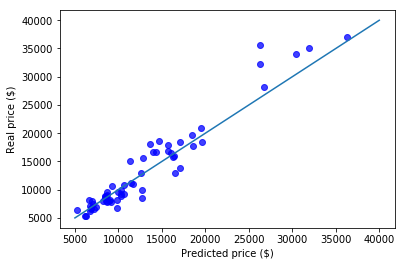

In [17]:
fig, ax = plt.subplots()

plt.xlabel("Predicted price ($)")
plt.ylabel("Real price ($)")

ax.scatter(np.exp(model.predict(X_test)), np.exp(y_test), alpha=.75, color='b')
ax.plot([5000, 40000], [5000, 40000])

#### Investigating model coefficients.

In [18]:
# Deciphering columns (after use of one hot encoder).

names = []

# The one hot encoder saves the mapping between the indices and the corresponding columns in the original dataframe
# in the properties feature_indices_ and with the mask active_features_.
feature_indices = model.best_estimator_.named_steps["onehotencoder"].feature_indices_
active_features = model.best_estimator_.named_steps["onehotencoder"].active_features_
for i in range(X_train[cat].shape[1]):
    for j in feature_indices[i] + range(feature_indices[i + 1] - feature_indices[i]):
        if j in active_features:
            names.append(X_train[cat].columns[i]) 

# Appends all the numeric columns used for the model which are not modified by the one hot encoder.
names = np.append(names, [column for column in num if column != "price"])

# Puts together the coefficients and the original column name of the dataframe and shows the variables with the most
# weight.
res = pd.DataFrame({
    'id': np.arange(0, len(names)), 
    'name': names,
    'coef': model.best_estimator_.named_steps["ridge"].coef_
})
res.set_index('id', inplace=True)
res = res.sort_values(by='coef', ascending=False)
res.head(10)

,coef,name
id,,
2,0.055922,make
53,0.052247,curb-weight
58,0.045107,horsepower
54,0.044412,engine-size
51,0.042092,width
50,0.036626,length
34,0.034064,drive-wheels
62,0.031523,number-of-cylinders
14,0.029139,make


## Question 4. 
### A. Explain each and every of your design choices (e.g., preprocessing, model selection, hyper parameters, evaluation criteria). Compare and contrast your choices with alternative methodologies. 

* Due to the small data set of 205 rows the aim was to implement a simple linear regression model. More complex models such as random forests or gradient boosting would have likely overfitted on the training set.

### Preprocessing.
* Rows and columns required for modeling of the car price were selected. Rows where the 'price' was missing were removed and columns related to insurance risk and loss payments excluded.
* The distribution of the target variable 'price' was plotted and its skewness determined which revealed a skewed distribution with a long tail. The variable was log transformed to reduce the skewness. A normally distributed target variable was desirable as linear regression models require the errors to be normally distributed along the regression line.
* As part of feature engineering the variable 'num-of-cylinders' was transformed from categorical to numerical by changing the numbering from text to a digit. In this way, the information of increasing numbers of cylinders was kept.
* For the later use of the one hot encoder the following preprocessing steps were performed. Categorical and numeric columns were identified as the one hot encoder transforms the categorical variables into several boolean variables. It requires the values of the variables to be numeric which is why the strings of the categorical values were transformed to codes. Finally, the position of the categorical variables within the data frame was determined which was required for the use of a transformer pipeline.
* The data was split into training (70%) and testing (30%) set.

### Model pipeline.
* Each model pipeline consisted of an imputer, the one hot encoder, a standard scaler and the model.
* The imputer was defined to impute categorical values with the mode and numeric values with the median.
* The one hot encoder transformed categorical variables into multiple boolean numeric variables.
* The standard scaler normalised the variables to have a mean of 0 and a standard deviation of 1.
* A pipeline was used for the purpose of easily conducting several preprocessing steps and to make sure to perform all transformations independently on training and testing set.


### Model selection.
* Due to the small sample size a simple linear regression model was chosen initially. However, due to the large number of variables with respect to the low number of data points the model overfitted largely on the training set.
* As a second approach a Ridge regularisation (L2 norm) model was used which helps to tune the variable weights. L2 norm regularisation shrinks the regression coefficients and thus prevents overfitting. 
* The Ridge regression model performed much better than the simple linear regression model and reduced overfitting on the training set.

### Hyper parameters.
* To improve the Ridge regularisation model and to further reduce overfitting the alpha hyperparameter which controls the strength of the regularisation was optimised by testing multiple values for alpha through cross validation using GridSearchCV.


### Evaluation criteria.
* For model evaluation R-squared and root mean squared error were used.
* R-squares is a measure of how close the data are to the fitted regression line. It varies from 0 to 1 with 1 meaning that all the variance in the target is explained by the data.
* Root mean squared error is the root of the mean squared errors of the model. It measures the distance between the predicted and the actual values. It can be more intuitive as it is scale-dependent and is useful to compare different models on the same data set.

### Model evaluation and investigation.
* The final Ridge regularisation model still overfits slightly on the training set with an R-squared of 0.95 for training and 0.91 for testing set. However, the R-squared close to 1 and the small RMSE indicates a good fit of the regression line to the data.
* The scatter plot of the real price versus the predicted price shows that the model predicts prices at the lower price range (~up to 20000 USD pretty well), however it underestimates all of the higher prices suggesting that a non-linear model may be more appropriate for this use case.
* Investigation of the model coefficients revealed the most important model coefficients.

### B. Describe how you would improve the model in Question 3 if you had more time.

### Feature engineering.
* Manually creating new features by combining other variables such as computing the size of the car using the variables length, width and height
* Some of the independent variables are skewed and could be transformed to be more normally distributed.
* Tree-based methods to find thresholds for categorical variables.

### Ridge model improvements.
* As outliers can affect regression models substantially by pulling the estimated regression line away from the data outlier they should either be removed or robustness regression algorithms be used to reduce their impact.

### Other models.
* As mentioned previously, high car prices are underestimated by the implemented Ridge regression model suggesting a nonlinear model may perform better in also correctly predicting these prices. Possibilities are for example Random Forest and Gradient Boosting regressors.